In [51]:
import argparse
import copy
import os
import sys
import time

import numpy as np
import pandas as pd
from pandas.core.arrays import boolean
import torch
from scipy import stats
from sklearn import preprocessing
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import models
import utils as ut
from models import AEBase, Predictor, PretrainedPredictor
from sklearn.metrics.cluster import adjusted_rand_score


import scanpypip.preprocessing as pp
import scanpypip.utils as scut 

import scanpy as sc

In [52]:
class Arguments:
    def __init__(self):   
        self.epochs = 500
        self.bottleneck = 512
        self.missing_value = np.nan
        self.target_data = "data/GSE108394/GSM2897334/"
        self.source_data = "data/GDSC2_expression.csv"
        self.test_size = 0.2
        self.valid_size = 0.2
        self.source_model_path = "saved/models/pretrained_novar.pkl"
        self.target_model_path = "saved/models/"
        self.logging_file = "saved/logs/"
        self.batch_size = 200
        self.source_h_dims = "2048,1024"
        self.target_h_dims = "512,256"

        self.var_genes_disp = 0
        self.pretrain_path = "saved/models/pretrained_novar.pkl"
        self.min_n_genes = 0
        self.max_n_genes = 20000
        self.min_g = 200
        self.min_c = 3

        
args = Arguments()

In [53]:
epochs = args.epochs
dim_au_out = args.bottleneck #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
na = args.missing_value
data_path = args.target_data
test_size = args.test_size
valid_size = args.valid_size
g_disperson = args.var_genes_disp
min_n_genes = args.min_n_genes
max_n_genes = args.max_n_genes
source_model_path = args.source_model_path
target_model_path = args.target_model_path 
pretrain_path = args.pretrain_path
log_path = args.logging_file
batch_size = args.batch_size
encoder_hdims = args.source_h_dims.split(",")
encoder_hdims = list(map(int, encoder_hdims))
source_data_path = args.source_data 


In [54]:
now=time.strftime("%Y-%m-%d-%H-%M-%S")
log_path = log_path+now+".txt"
export_name = data_path.replace("/","")
pretrain_path = "saved/models/ae_"+export_name+now+".pkl"

In [55]:
#scv = pd.read_csv('data/GSE117872/GSE117872_good_Data_TPM.txt',sep="\t")

In [56]:
adata.obs['sens'] = adata.obs['sens_preds'] 

In [57]:
adata = sc.read_h5ad('saved/resultsGSE1178722020-11-24-20-31-23.h5ad')

In [58]:
# Process annotations

# annotation = pd.read_csv('data/GSE117872/GSE117872_good_Data_cellinfo.txt',sep="\t",index_col='groups')

# annotation.pca_clusters

# for item in annotation.columns:
#     #print(annotation.loc[:,item])
#     #if(annotation.loc[:,item].dtype == object):
#     adata.obs[str(item)] = annotation.loc[:,item].convert_dtypes('category').values
#     #else:
#         #adata.obs[str(item)] = annotation.loc[:,item].values

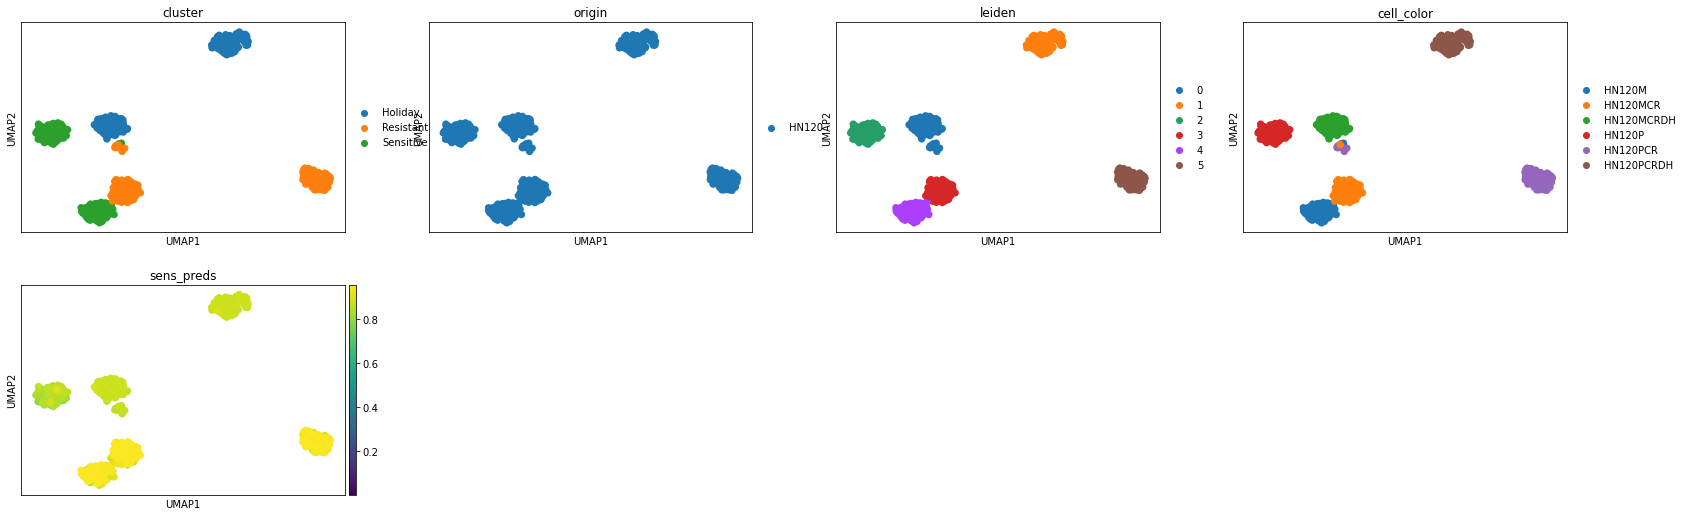

In [60]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=0.5)
sc.pl.umap(adata,color=["cluster","origin","leiden","cell_color",'sens_preds'])

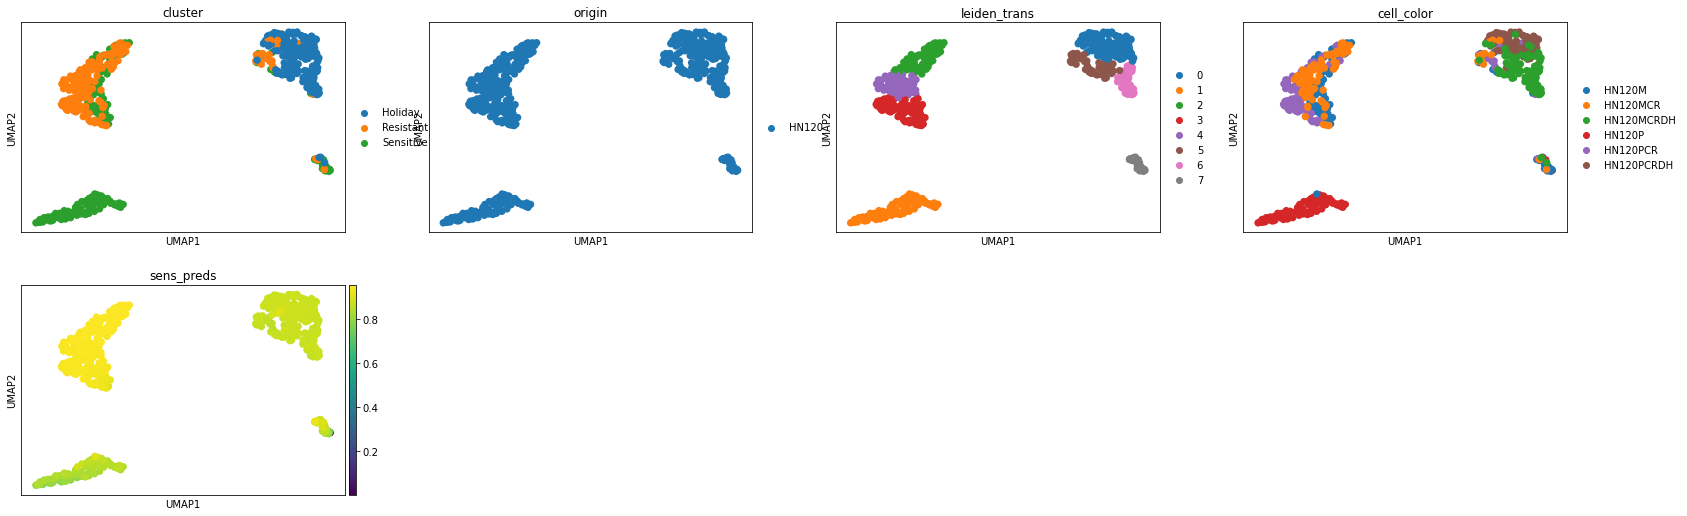

In [61]:
sc.pp.neighbors(adata,use_rep='X_AE',key_added="Trans")
sc.tl.umap(adata,neighbors_key="Trans")
sc.tl.leiden(adata,neighbors_key="Trans",key_added="leiden_trans",resolution=0.5)
sc.pl.umap(adata,color=["cluster","origin","leiden_trans","cell_color","sens_preds"],neighbors_key="Trans")

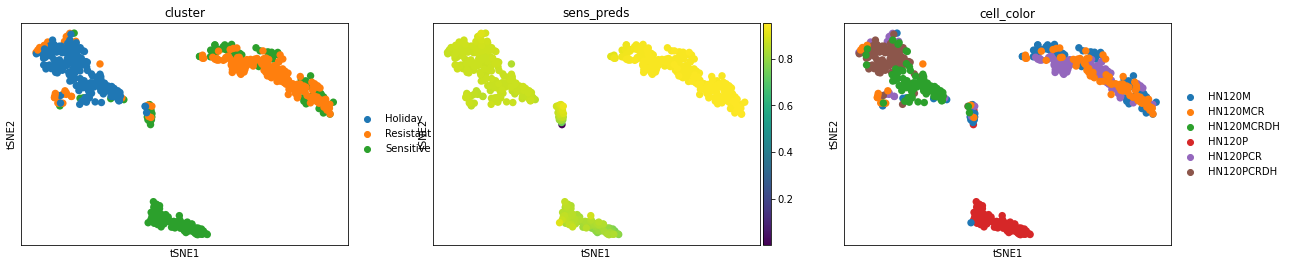

In [62]:
sc.pl.tsne(adata,color=["cluster","sens_preds","cell_color"])


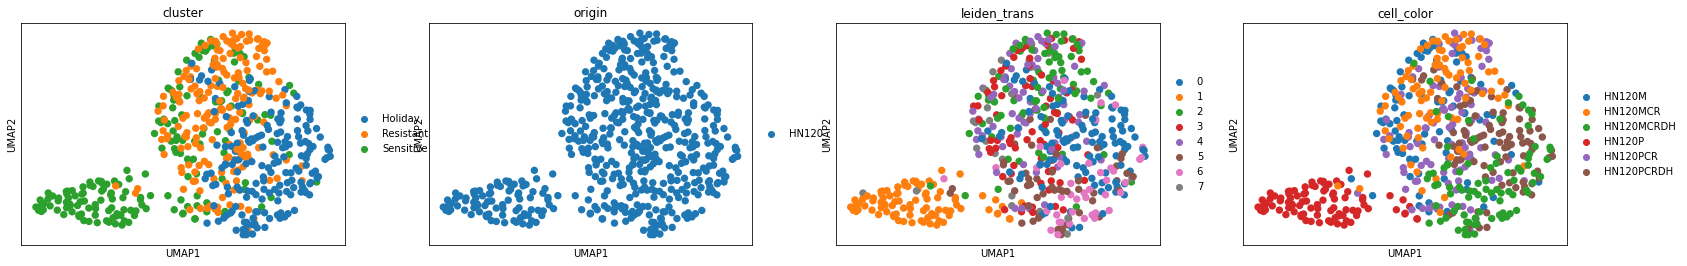

In [63]:
sc.pp.neighbors(adata,use_rep='X_pre',key_added="Pret")

sc.tl.umap(adata,neighbors_key="Pret")
sc.tl.leiden(adata,neighbors_key="Pret",key_added="leiden_Pret",resolution=0.5)
sc.pl.umap(adata,color=["cluster","origin","leiden_trans","cell_color"],neighbors_key="Pret")

In [ ]:
adjusted_rand_score(adata.obs["leiden"], adata.obs["cell_color"])

In [ ]:
adjusted_rand_score(adata.obs["leiden_trans"], adata.obs["cell_color"])

In [ ]:
adjusted_rand_score(adata.obs["leiden_trans"], adata.obs["leiden"])

In [ ]:
adata